In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visualkeras
!pip install tensorflow_addons


     |████████████████████████████████| 992 kB 11.0 MB/s 
     |████████████████████████████████| 1.1 MB 13.1 MB/s 


In [3]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

import random
import os
import keras
import visualkeras

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16
from keras import optimizers, layers, applications

In [4]:
filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

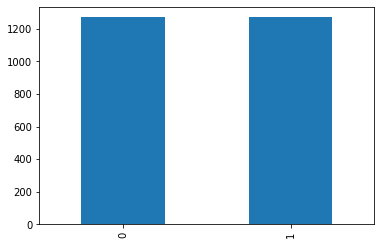

In [5]:
train_df['category'].value_counts().plot.bar()

In [6]:
test_filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/AutismDataset/test")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

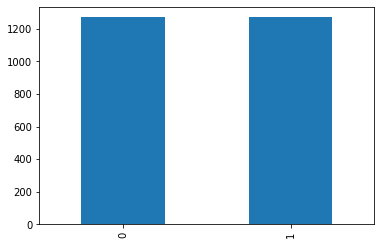

In [7]:
test_df['category'].value_counts().plot.bar()

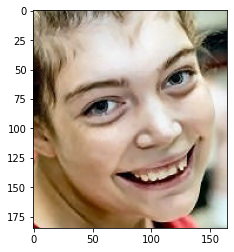

In [8]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/"+sample)
plt.imshow(image)

In [9]:
image_size = 224

In [10]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()



total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=64
)

Found 2286 validated image filenames belonging to 2 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Colab Notebooks/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=64
)

Found 254 validated image filenames belonging to 2 classes.


In [13]:
model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


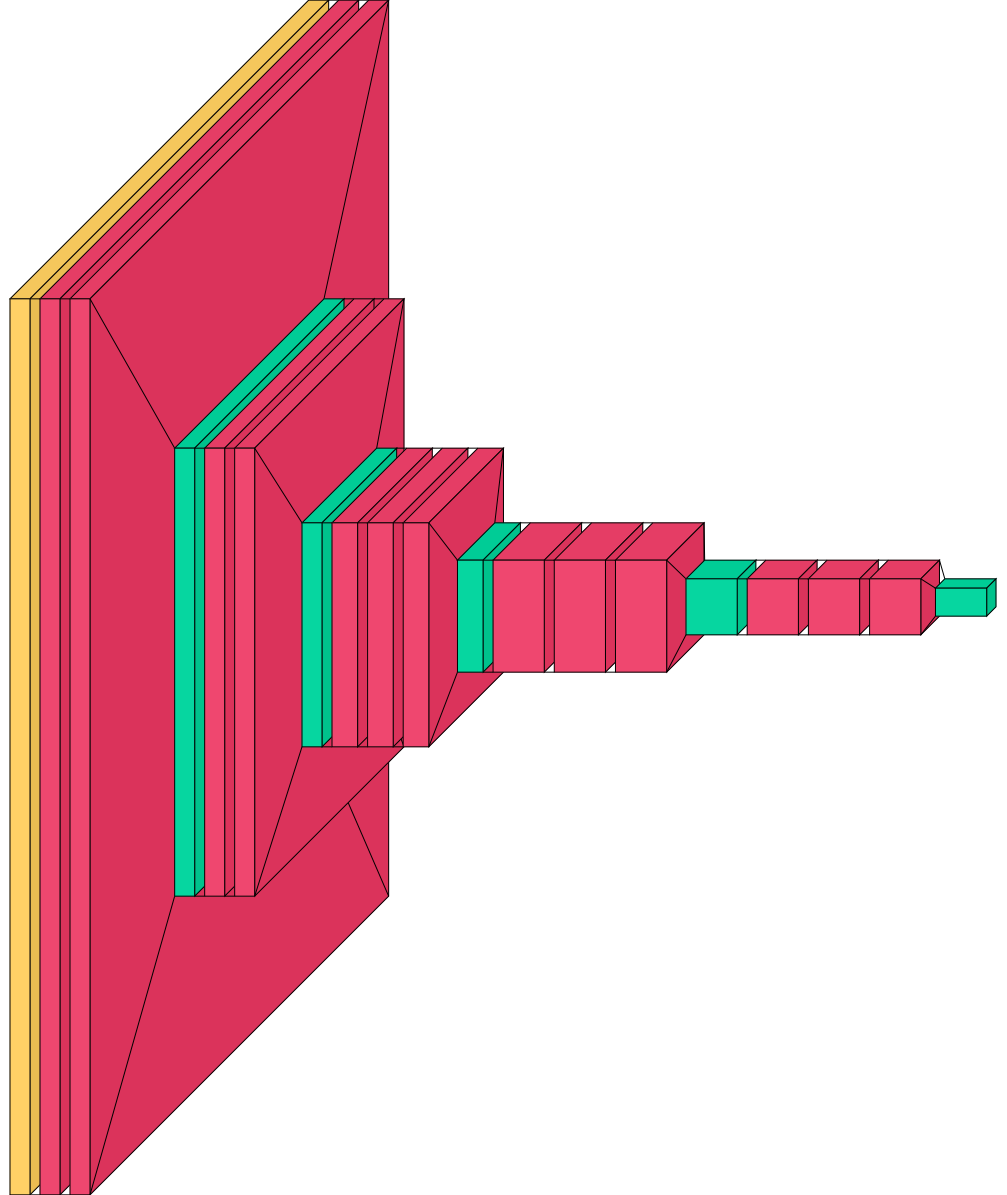

In [14]:
visualkeras.layered_view(model)

In [15]:
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)

In [16]:
VGG = Model(model.input, x)

VGG.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

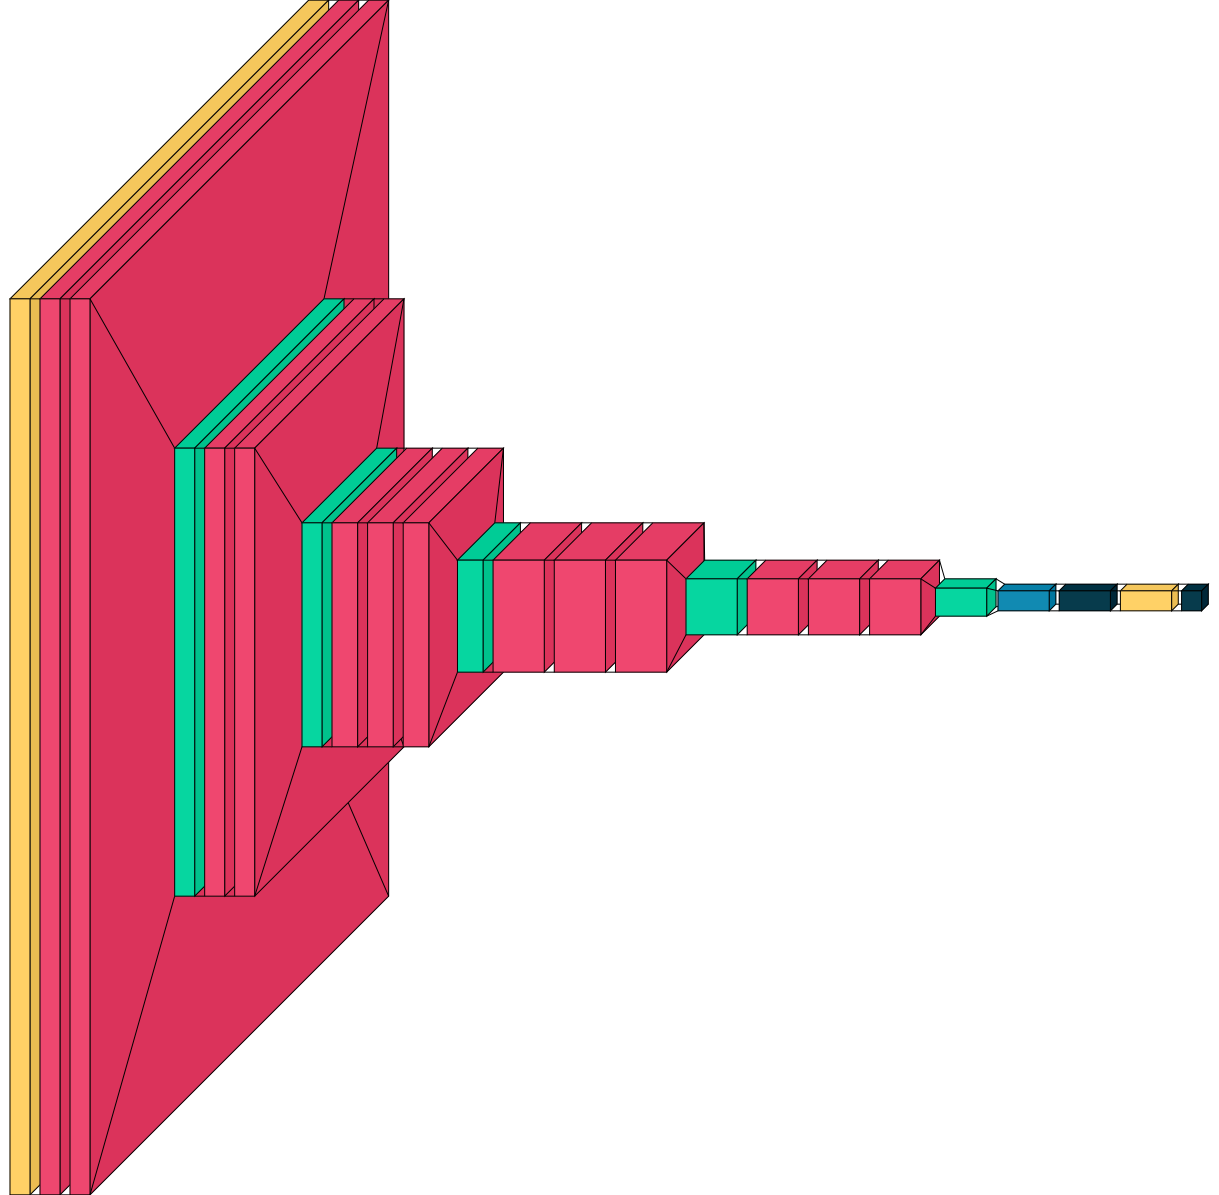

In [17]:
visualkeras.layered_view(VGG)

In [18]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='acuracia'),
      tf.keras.metrics.Precision(name='precisão'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [20]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [21]:
VGG.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
              metrics=METRICS)

#VGG.compile(optimizer='optimizers.SGD(lr=1e-3, momentum=0.9)', loss='categorical_crossentropy',metrics=METRICS)

#optimizer=optimizers.SGD(lr=1e-3, momentum=0.9))



In [ ]:
history = VGG.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=total_validate//64,
)

'''
history = VGG.fit(train_generator,
                  validation_data=validation_generator,
                    validation_steps=total_validate//64,
                    epochs = 20,
                    steps_per_epoch=total_train//64,
                    verbose = 1,
                    callbacks=lr_scheduler)
'''

Epoch 1/200
36/36 [==============================] - 96s 2s/step - loss: 0.7602 - acuracia: 0.5236 - precisão: 0.5236 - recall: 0.5236 - auc: 0.5306 - f1_score: 0.5233 - val_loss: 0.6331 - val_acuracia: 0.7031 - val_precisão: 0.7031 - val_recall: 0.7031 - val_auc: 0.7896 - val_f1_score: 0.7031
Epoch 2/200
36/36 [==============================] - 61s 2s/step - loss: 0.6222 - acuracia: 0.6518 - precisão: 0.6518 - recall: 0.6518 - auc: 0.7079 - f1_score: 0.6515 - val_loss: 0.4913 - val_acuracia: 0.7969 - val_precisão: 0.7969 - val_recall: 0.7969 - val_auc: 0.8710 - val_f1_score: 0.7969
Epoch 3/200
36/36 [==============================] - 60s 2s/step - loss: 0.5547 - acuracia: 0.7152 - precisão: 0.7152 - recall: 0.7152 - auc: 0.7892 - f1_score: 0.7149 - val_loss: 0.5427 - val_acuracia: 0.7135 - val_precisão: 0.7135 - val_recall: 0.7135 - val_auc: 0.8060 - val_f1_score: 0.7135
Epoch 4/200
36/36 [==============================] - 60s 2s/step - loss: 0.5105 - acuracia: 0.7585 - precisão: 0.75

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
train_data, train_labels = train_generator.next()

In [ ]:
#Dividindo os dados em conjuntos de treinamento, teste e validação

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
test_scores = VGG.evaluate(test_data, test_labels)

print("Accuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
print("F1_score = ", test_scores[5])

In [ ]:
pred_labels = VGG.predict(test_data)

In [ ]:
kpred = VGG.predict(test_data)

In [ ]:
pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
CLASSES = [ 'Autistic',
            'Non_Autistic'
            ]

In [ ]:
#Como os rótulos são arrays softmax, precisamos arredondar para tê-los na forma de 0s e 1s,
#semelhante aos test_labels
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
#Plotar a matriz de confusão para entender a classificação em detalhes

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Diagnóstico da Doença de Alzheimer')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show(ax)